<a href="https://colab.research.google.com/github/sayakpaul/GAN-Hacks/blob/master/WGAN_GP_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Select TensorFlow 2 backend
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
# I'm training on a GPU!
!nvidia-smi

Thu Mar 19 11:50:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Imports
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from IPython.display import clear_output
from imutils import build_montages
from sklearn.utils import shuffle 
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [0]:
# Set TensorFlow's and NumPy's random seed and make the plots inline
tf.random.set_seed(42)
np.random.seed(42)
%matplotlib inline

In [5]:
# Gather dataset
((X_train, _), (X_test, _)) = tf.keras.datasets.fashion_mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
# Add a channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [0]:
# Shuffle the datapoints to avoid order bias
X_train, X_test = shuffle(X_train), shuffle(X_test)

# Concatenate train and test images into one array and normalize
# the pixel values
trainImages = np.concatenate([X_train, X_test])
trainImages = (trainImages.astype("float32") - 127.5) / 127.5

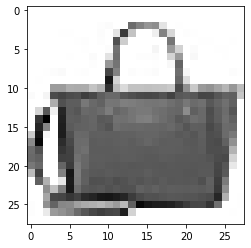

In [8]:
plt.imshow(trainImages[0].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

In [0]:
# Model configuration
LATENT_DIM = 100
HEIGHT = 28
WIDTH = 28
NB_CHANNELS = 1

In [0]:
# Generator
def generator_network():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=LATENT_DIM, units=512, use_bias=False))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64, use_bias=False))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same", use_bias=False))
    generator.add((LeakyReLU()))
    generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(NB_CHANNELS, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))

    return generator

In [11]:
generator = generator_network()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51200     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1605632   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0

In [0]:
# Discriminator
def disc_network():
    disc = Sequential()
    inputShape = (HEIGHT, WIDTH, NB_CHANNELS)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    
    return disc

In [13]:
disc = disc_network()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)              

In [0]:
# The Wasserstein loss
from tensorflow.keras import backend as K

def wasserstein(y_true, y_pred):
    return - K.mean(y_true * y_pred)

In [0]:
# Compile the critic (in the W-GAN paper the authors referred the discriminator as critic)
disc_opt = Adam(lr=0.0002, beta_1=0.5)
gan_opt = Adam(lr=0.0002, beta_1=0.5)

In [0]:
# Reference: https://colab.research.google.com/drive/14l-3syle0APnRi-HQoTx-oAFZOGvbbSk

@tf.function
def train_gan(num_samples):
    # 1. Generate random noise
    noise = np.random.normal(size=(num_samples, LATENT_DIM))
    noise = tf.convert_to_tensor(noise, dtype=tf.float32)

    # 2. Generate fake labels to fool the critic
    fake_labels = np.array([1] * BATCH_SIZE)
    fake_labels = tf.convert_to_tensor(fake_labels, dtype=tf.float32)

    # 3. Generate image and get the loss as well as gradients via the critic
    with tf.GradientTape() as tape:
        generated_images = generator(noise, training=True)
        gen_img_logits = disc(generated_images, training=True)
        gan_loss = wasserstein(fake_labels, gen_img_logits)
    
    gen_gradient = tape.gradient(gan_loss, generator.trainable_variables)
    gan_opt.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    return gan_loss

#-------------------------------------------------------------------------------

def gradient_penalty(real_images, fake_images):
    # Each image would get a random number in the batch 
    # This number would be of shape: (num_samples, 1, 1, 1)
    # Remember each image has h x w x nb_channels
    alpha = np.random.uniform(size=(len(real_images), 1, 1, 1))
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    
    # Perform interpolation
    interpolated = (alpha * real_images) + ((1 - alpha) * fake_images)
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = disc(interpolated, training=True)

    # Compute the Gradient Penalty term
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    
    return gp

#-------------------------------------------------------------------------------

@tf.function
def train_critic(real_images, gp_weight=10.0):
    # 1. Map random noise to images via the generator
    noise = np.random.normal(size=(len(real_images), LATENT_DIM))
    noise = tf.convert_to_tensor(noise, dtype=tf.float32)
    generated_images = generator(noise, training=True)
    
    # 2. Combine the real and generated images
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # 3. Prepare the labels
    # -1 -> Fake images, 1 -> Real images
    labels = np.array(([-1] * BATCH_SIZE) + ([1] * BATCH_SIZE)).astype("float")
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    # 4. Compute the critic loss with GP and update gradients
    with tf.GradientTape() as tape:
        critic_logits = disc(combined_images, training=True)
        disc_loss = wasserstein(labels, critic_logits)
        
        gp = gradient_penalty(real_images, generated_images)
        total_critic_loss = disc_loss + gp*gp_weight

    disc_gradient = tape.gradient(total_critic_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(disc_gradient, disc.trainable_variables))
    
    return total_critic_loss

#-------------------------------------------------------------------------------

In [0]:
# Constants
EPOCHS = 10000 
BATCH_SIZE = 32

In [0]:
# Metrics to keep track of the mean loss for eah epoch
gen_metric = tf.keras.metrics.Mean()
disc_metric = tf.keras.metrics.Mean()

In [0]:
# Sample random noise from a normal distribution, we will use this
# to visualize the intermediate results
benchmark_noise = np.random.normal(size=(256, LATENT_DIM))

In [0]:
######## Training ########
##########################

start = 0

for epoch in tqdm(range(EPOCHS)):
    # Calculate where to stop the current epoch, segregate the current batch
    # of real images and combine them with the fake ones
    stop = start + BATCH_SIZE
    real_images = trainImages[start:stop]

    # Frequent critic updates in between generator updates
    for _ in range(5):
        critic_loss = train_critic(real_images)
        disc_metric(critic_loss)
    
    # Train the GAN
    gan_loss = train_gan(BATCH_SIZE)
    gen_metric(gan_loss)

    # Set the next batch
    start += BATCH_SIZE
    if start > len(trainImages) - BATCH_SIZE:
        start = 0
    
    # Logging
    if epoch % 200==0:            
        print(f"epoch: {epoch} gan_loss: {gen_metric.result():.3f}, d_loss: {disc_metric.result():.3f}")
        predicted_images = generator.predict(benchmark_noise)
        predicted_images = ((predicted_images * 127.5) + 127.5).astype("int")
        predicted_images = np.repeat(predicted_images, 3, axis=-1)
        vis = build_montages(predicted_images, (28, 28), (16, 16))[0]
        cv2.imwrite("vis" + str(epoch) + ".png", vis)

    # Reset the states of the metrics
    gen_metric.reset_states()
    disc_metric.reset_states()

  0%|          | 1/10000 [00:03<10:19:13,  3.72s/it]

epoch: 0 gan_loss: 0.018, d_loss: 6.554


  2%|▏         | 203/10000 [00:16<10:48, 15.10it/s]

epoch: 200 gan_loss: -14.236, d_loss: 0.015


  4%|▍         | 403/10000 [00:28<10:32, 15.18it/s]

epoch: 400 gan_loss: -16.523, d_loss: 0.016


  6%|▌         | 603/10000 [00:40<10:21, 15.13it/s]

epoch: 600 gan_loss: -16.798, d_loss: 0.017


  8%|▊         | 803/10000 [00:52<10:10, 15.06it/s]

epoch: 800 gan_loss: -17.277, d_loss: 0.014


 10%|█         | 1003/10000 [01:04<09:57, 15.06it/s]

epoch: 1000 gan_loss: -16.660, d_loss: 0.013


 12%|█▏        | 1203/10000 [01:16<09:39, 15.17it/s]

epoch: 1200 gan_loss: -17.042, d_loss: 0.011


 14%|█▍        | 1403/10000 [01:28<09:30, 15.07it/s]

epoch: 1400 gan_loss: -17.520, d_loss: 0.010


 16%|█▌        | 1603/10000 [01:40<09:09, 15.29it/s]

epoch: 1600 gan_loss: -17.763, d_loss: 0.019


 18%|█▊        | 1803/10000 [01:52<09:04, 15.06it/s]

epoch: 1800 gan_loss: -18.119, d_loss: 0.010


 20%|██        | 2003/10000 [02:04<08:50, 15.07it/s]

epoch: 2000 gan_loss: -18.445, d_loss: 0.012


 22%|██▏       | 2203/10000 [02:16<08:29, 15.31it/s]

epoch: 2200 gan_loss: -18.137, d_loss: 0.010


 24%|██▍       | 2403/10000 [02:28<08:23, 15.09it/s]

epoch: 2400 gan_loss: -18.497, d_loss: 0.010


 26%|██▌       | 2603/10000 [02:40<08:06, 15.22it/s]

epoch: 2600 gan_loss: -18.134, d_loss: 0.012


 28%|██▊       | 2803/10000 [02:52<07:58, 15.03it/s]

epoch: 2800 gan_loss: -18.256, d_loss: 0.010


 30%|███       | 3003/10000 [03:04<07:39, 15.23it/s]

epoch: 3000 gan_loss: -17.783, d_loss: 0.011


 32%|███▏      | 3203/10000 [03:16<07:33, 14.99it/s]

epoch: 3200 gan_loss: -18.256, d_loss: 0.011


 34%|███▍      | 3403/10000 [03:28<07:14, 15.20it/s]

epoch: 3400 gan_loss: -18.686, d_loss: 0.011


 36%|███▌      | 3603/10000 [03:40<07:14, 14.72it/s]

epoch: 3600 gan_loss: -18.174, d_loss: 0.009


 38%|███▊      | 3803/10000 [03:52<06:43, 15.34it/s]

epoch: 3800 gan_loss: -17.517, d_loss: 0.009


 40%|████      | 4003/10000 [04:04<06:30, 15.37it/s]

epoch: 4000 gan_loss: -18.080, d_loss: 0.008


 42%|████▏     | 4203/10000 [04:16<06:19, 15.26it/s]

epoch: 4200 gan_loss: -17.794, d_loss: 0.011


 44%|████▍     | 4403/10000 [04:28<06:07, 15.24it/s]

epoch: 4400 gan_loss: -17.332, d_loss: 0.012


 46%|████▌     | 4603/10000 [04:40<05:56, 15.14it/s]

epoch: 4600 gan_loss: -17.733, d_loss: 0.008


 48%|████▊     | 4803/10000 [04:52<05:37, 15.41it/s]

epoch: 4800 gan_loss: -17.643, d_loss: 0.008


 50%|█████     | 5003/10000 [05:04<05:25, 15.33it/s]

epoch: 5000 gan_loss: -17.687, d_loss: 0.010


 52%|█████▏    | 5203/10000 [05:16<05:19, 15.03it/s]

epoch: 5200 gan_loss: -17.670, d_loss: 0.011


 54%|█████▍    | 5403/10000 [05:28<05:05, 15.07it/s]

epoch: 5400 gan_loss: -17.566, d_loss: 0.009


 56%|█████▌    | 5603/10000 [05:40<04:48, 15.25it/s]

epoch: 5600 gan_loss: -17.844, d_loss: 0.009


 58%|█████▊    | 5803/10000 [05:52<04:33, 15.32it/s]

epoch: 5800 gan_loss: -17.195, d_loss: 0.010


 60%|██████    | 6003/10000 [06:04<04:20, 15.37it/s]

epoch: 6000 gan_loss: -17.582, d_loss: 0.007


 61%|██████    | 6051/10000 [06:07<03:54, 16.82it/s]

In [0]:
def show_montage(image_path)
    montage_1 =  plt.imread(image_path)
    plt.imshow(montage_1, cmap=plt.cm.binary)
    plt.show()

In [0]:
montage_2 =  plt.imread("vis2000.png")
plt.imshow(montage_2)
plt.show()

In [0]:
montage_3 =  plt.imread("vis5000.png")
plt.imshow(montage_3)
plt.show()

In [0]:
montage_4 =  plt.imread("vis7000.png")
plt.imshow(montage_4)
plt.show()

In [0]:
montage_5 =  plt.imread("vis9500.png")
plt.imshow(montage_5)
plt.show()